In [2]:
import os
from timeit import default_timer as timer
import cv2
import numpy as np
import matplotlib.pyplot as plt
#import h5py
import tifffile
#from joblib import Parallel, delayed
%matplotlib inline
print("OpenCV Version : {0}".format(cv2.__version__))
print("Numpy Version : {0}".format(np.__version__))

OpenCV Version : 3.1.0
Numpy Version : 1.10.4


In [2]:
def playMovie(A,newMinMax=False):
    #play movie in opencv after normalizing display range
    #A is float input (float32)
    #newMinMax is an optional tuple of length 2, the new display range
    #Note: the array normalization is done inplace, thus the array will be rescaled outside scope of this function (but will still be float32)
    cv2.startWindowThread()
    cv2.namedWindow("raw", cv2.WINDOW_NORMAL) #Create a resizable window
    i = 0
    
    #if newMinMax:
        #im = cv2.normalize(im, None, newMinMax[0], newMinMax[1], cv2.NORM_MINMAX)
        #im = cv2.normalize(im, None, newMinMax[0], newMinMax[1], cv2.NORM_L2)
        #im = cv2.equalizeHist(im)
        #im,cdf = histeq(im)
        #im -= newMin
        #im *= newSlope
        #cv2.normalize(im,im,newMinMax[0],newMinMax[1],cv2.NORM_MINMAX)
    
    #Normalize movie range and change to uint8 before display
    A = np.reshape(A, (sz[0], A.size/sz[0]))
    meanA,stdA = cv2.meanStdDev(A)
    print("mean: {0}, std: {1}".format(meanA,stdA))
    
    if newMinMax == False:
        newMin = meanA - 3*stdA
        newMax = meanA + 7*stdA
    else:
        newMin = newMinMax[0]
        newMax = newMinMax[1]
    
    newSlope = 255.0/(newMax-newMin)
    #A += abs(np.amin(A))
    cv2.subtract(A, newMin, A)
    cv2.multiply(A, newSlope, A)
    A = np.reshape(A, sz)
    A = A.astype('uint8', copy=False)
    
    while True:
        #im = np.uint8(A3[:,:,i] * 255)
        im = A[i,:,:]
        #im = cv2.GaussianBlur(im,(0,0),3)
        #th,bw = cv2.threshold(im,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        #bw = cv2.adaptiveThreshold(im,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,5,0)
        im = cv2.applyColorMap(im, cv2.COLORMAP_JET)
        cv2.imshow('raw',im)
        k = cv2.waitKey(10) 
        if k == 27: #if esc is pressed
            break
        if k == ord('b'):
            i -= 1000
        elif k == ord('f'):
            i += 1000
        else:
            i += 1
        if (i > (A.shape[0]-1)) or (i < 0) :
            i = 0

    cv2.destroyAllWindows()




/Users/ackman/anaconda/envs/py35/lib/python3.5/site-packages/tifffile/tifffile.py:1974: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


(3000, 540, 640)
False
1.6386002310318872
False
(3000, 540, 640)
3
(540, 640)
2


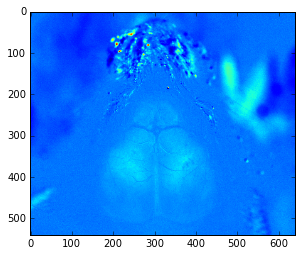

In [5]:
t0 = timer()
fn = '/Users/ackman/Desktop/140509_21.tif'
#fn = '/Users/ackman/Data/2photon/120518i/120518_07_fr1-300.tif'
with tifffile.TiffFile(fn) as tif:
    A = tif.asarray()

del(tif)
print(A.shape)
print(np.isfortran(A))
sz = A.shape
A = A.astype('float32', copy=False)
Amean = np.mean(A,axis=0)
#A = np.rollaxis(A, 0, 3)
#A = np.reshape(A, (A.shape[0], A.size/A.shape[0]))
t0=timer()
for i in np.arange(A.shape[0]):
    A[i,:,:] = ((A[i,:,:] / Amean) - 1.0)
print(timer()-t0)
print(np.isfortran(A))
print(A.shape)
print(A.ndim)
print(Amean.shape)
print(Amean.ndim)
plt.imshow(A[9,:,:])

In [4]:
playMovie(A)

mean: [[  6.86191114e-10]], std: [[ 0.09794486]]


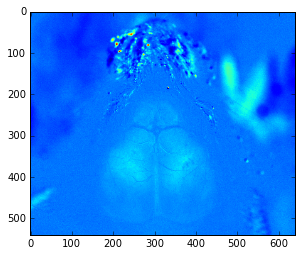

In [37]:
plt.imshow(A[9,:,:])

This takes just 0.32 s to read in 300fr array at its ** default uint16.**
And takes 0.78 s to read in array and cast as float64.
Matlab takes 2.11 s to read in same array into a float64.


Takes 13 s read in 3000fr array and convert to float64.
Takes just 4.5s to read in 3000fr array as default uint16.
Takes 4.6s to read in 3000fr array as float32 with astype(copy=False)


Reshaping the array can change from c index ordering to fortran ordering. Reshaping can also end up making a copy, so timing needs to be tested carefully.

In [66]:
%timeit np.mean(A,axis=0)
A = np.reshape(A, (A.shape[0], A.size/A.shape[0]))
%timeit np.mean(A,axis=0)
%timeit np.mean(A,axis=1)

1 loop, best of 3: 389 ms per loop
1 loop, best of 3: 392 ms per loop
1 loop, best of 3: 429 ms per loop


With the stridetracks 3D vectorized dfof it is slow: 

* <1 for the dfof calculation for 300fr float64.
* 13 s for the dfof calculation for 3000fr float64.
* 1.8 s - 5s for the dfof calculation for 3000fr float32

With a for loop iterating over frames it is fast: 

* 0.5 ms for the dfof calculation for 3000fr float32 in a for loop by frames

1000 loops, best of 3: 159 µs per loop
10000 loops, best of 3: 171 µs per loop
10000 loops, best of 3: 94.3 µs per loop
The slowest run took 6.75 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 114 µs per loop


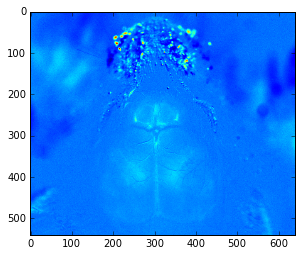

In [84]:
%timeit (A[0,:,:] / Amean)
%timeit (cv2.divide(A[0,:,:], Amean))

im2 = A[0,:,:] / Amean
%timeit im2 - 1
#plt.imshow((A[0,:,:] / Amean) - 1.0)

im = cv2.divide(A[0,:,:], Amean)
%timeit cv2.subtract(im, 1)
plt.imshow(im)

In [95]:
%timeit dfof(A,Amean)

1000 loops, best of 3: 500 µs per loop


In [70]:
#A = np.reshape(A,sz)
#A = np.reshape(A, (A.size/sz[2], sz[2]))
#print(A.shape)
#print(A.dtype)
#t0=timer()
%timeit np.std(A) 
meanA = np.mean(A)
stdA = np.std(A)
print(meanA)
print(stdA)
#print(timer()-t0)
#print(meanA)
#t0=timer()
%timeit cv2.meanStdDev(A)
cvMean,cvStd = cv2.meanStdDev(A)
print(cvMean)
print(cvStd)
#print(timer()-t0)

1 loop, best of 3: 7.17 s per loop
4737.88984468
1648.2682435
1 loop, best of 3: 933 ms per loop
[[ 4737.88984468]]
[[ 1648.26814388]]


Array shape matters for opencv calculations:

    for float32 roll axis (x,y,z):
    np mean 1 loop, best of 3: 425 ms per loop
    cv2 mean 1 loop, best of 3: 12.9 s per loop

    for float32 tifffile default (z,x,y): 
    np mean 1 loop, best of 3: 428 ms per loop
    cv2 mean 1 loop, best of 3: 345 ms per loop


    for float32 tifffile default (z,x,y):
    np std 1 loop, best of 3: 3.49 s per loop
    cv2 meanStdDev 1 loop, best of 3: 944 ms per loop

    for float32 tifffile default with reshape (z, x*y) (still c-style ordering): 
    np std 1 loop, best of 3: 3.48 s per loop
    cv2 meanStdDev 1 loop, best of 3: 265 ms per loop

    np mean and std values: 
    4737.88
    1648.28
    cv2 mean and std values: 
    [[ 4737.88984468]]
    [[ 1648.26814388]]


    for uint16 tifffile default (z,x,y):  
    np mean and std values: 
    1 loop, best of 3: 7.17 s per loop
    4737.88984468
    1648.2682435
    cv2 mean and std values: 
    1 loop, best of 3: 933 ms per loop
    [[ 4737.88984468]]
    [[ 1648.26814388]]



In [60]:
print(stdA.dtype)
print(stdA.ndim)
print(stdA.shape)
print(cvStd.dtype)
print(cvStd.ndim)
print(cvStd.shape)

float32
0
()
float64
2
(1, 1)


In [11]:
meanA,stdA = cv2.meanStdDev(A)
newMin = meanA - 3*stdA
newMax = meanA + 7*stdA
print(newMin)
print(newMax)
t0=timer()
A -= newMin
A *= 255.0/(newMax-newMin)
print(timer()-t0)

t0=timer()
#np.clip(A, 0, 255, out=A)
A.clip(0, 255) #faster than the documented np.clip(A,min,max,out=A) which should be inplace. Possible version/memory leak issue
print(timer()-t0)
print(A.shape)



[[ 1435.94999875]]
[[ 12987.09259954]]
4.172961006057449
6.8788205049932
(3000, 540, 640)


In [24]:
A = np.reshape(A, (A.size/sz[2], sz[2]))

t0=timer()
meanA = np.mean(A) 
stdA = np.std(A)
newMin = meanA - 2*stdA
newMax = meanA + 5*stdA
print(timer()-t0)

t0=timer()
A -= newMin
A *= 255.0/(newMax-newMin)
print(timer()-t0)

t0=timer()
#np.clip(A, 0, 255, out=A)
A.clip(0, 255) #faster than the documented np.clip(A,min,max,out=A) which should be inplace. Possible version/memory leak issue
print(timer()-t0)

A = np.reshape(A,sz)

3.87034606934
0.973430871964
2.72590303421


with 300fr float64:

    <few s

with 3000fr float64: 

    55.4744589329
    22.1628820896
    75.272135973

with 3000fr float32: 

    4.15756678581
    0.929126977921
    2.98598194122


In [ ]:
#playMovie(A,(newMin,newMax))
playMovie(A)
#playMovie(A.astype('uint8', copy=False))

In [8]:
A = np.reshape(A, (sz[0], A.size/sz[0]))
#%timeit np.reshape(A, (sz[0], A.size/sz[0]))
print(A.shape)
#%timeit cv2.meanStdDev(A)
%timeit np.reshape(A, sz)
A = np.reshape(A, sz)
print(A.shape)

(3000, 345600)
The slowest run took 11.03 times longer than the fastest. This could mean that an intermediate result is being cached.
1000000 loops, best of 3: 978 ns per loop
(3000, 540, 640)


A reshaped into 2D:  
cv2 meanStdDev: 295 ms

A as default 3D: 
cv2 meanStdDev: 1030 ms

np.reshape 2D: 2.61 µs
np.reshape 3D: 974 ns

So it is worth reshaping the array into 2D before doing array calcs in opencv.

In [14]:
t0=timer()
A = np.reshape(A, (sz[0], A.size/sz[0]))
meanA,stdA = cv2.meanStdDev(A)
newMin = meanA - 3*stdA
newMax = meanA + 7*stdA
newSlope = 255.0/(newMax-newMin)
#A -= newMin
#A *= newSlope
cv2.subtract(A, newMin, A)
cv2.multiply(A, newSlope, A)
A = np.reshape(A, sz)
print(timer()-t0)

2.0874224869767204


With cv2 substract and multiply:  1.85 s
With np inplace operators for subtract and multiply: 3.41 s

In [2]:
A = cv2.imread('/Users/ackman/Desktop/140509_21.tif', -1)

This only reads in a single frame using cv2 to read in the tiff. The <0 flag indicates not to convert to 8bit automatically.

In [11]:
#print(np.amin(A))
#print(np.amax(A))
print(A.dtype)
print(A.shape)
print(np.isfortran(A))

uint16
(6000, 540, 640)
False


In [6]:
A = tifffile.imread([fn,fn])

/Users/ackman/anaconda/envs/py35/lib/python3.5/site-packages/tifffile/tifffile.py:1974: UserWarning: tags are not ordered by code
  warnings.warn("tags are not ordered by code")


In [9]:
A = np.reshape(A, (A.shape[0]*A.shape[1], A.shape[2], A.shape[3])) #reshape multiple arrays into one

In [8]:
np.arange(2,3)

array([2])